# Predicción del abandono (BURNOUT) de empleados
---

En primer lugar, importamos las librerías básicas para hacer el trabajo.

Para el preprocesamiento y carga de los datos.


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import set_config
from sklearn.compose import ColumnTransformer
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt


## Carga de los datos

El primer paso a seguir es cargar los datos para poder trabajar sobre ellos y construir un modelo que prediga si un empleado va a abandonar la empresa.

In [2]:
#import pandas as pd

df = pd.read_pickle('attrition_available_12.pkl')
#value_counts

#jobINvolment = df['JobInvolvement']
#print(jobINvolment.value_counts())

## Análisis exploratorio de datos

Ver las primeras filas del dataframe para tener una idea de cómo están estructurados los datos.

In [3]:
df.head()

,hrs,absences,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,Attrition,BusinessTravel,...,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
1,7.315971,13.0,2.0,NaN,3.0,2.0,4.0,31.0,Yes,Travel_Frequently,...,0.0,Y,NaN,8.0,1.0,6.0,3,NaN,1.0,4.0
6,NaN,17.0,3.0,NaN,1.0,3.0,1.0,28.0,Yes,Travel_Rarely,...,2.0,Y,NaN,8.0,1.0,5.0,2,0.0,NaN,0.0
13,NaN,14.0,2.0,3.0,1.0,2.0,2.0,47.0,Yes,Non-Travel,...,1.0,Y,11.0,NaN,2.0,10.0,4,10.0,9.0,9.0
28,10.713066,6.0,2.0,3.0,4.0,NaN,1.0,NaN,Yes,NaN,...,3.0,Y,14.0,8.0,1.0,19.0,2,1.0,0.0,NaN
30,9.662808,NaN,2.0,3.0,1.0,2.0,3.0,26.0,Yes,Travel_Rarely,...,2.0,Y,11.0,8.0,0.0,5.0,5,3.0,0.0,2.0


Debemos tener en cuenta que lo que queremos predecir es la columna '`attrition`', que mide si el empleado va a dejar el trabajo o no.

Ver los tipos de datos de las columnas

In [4]:
df.dtypes

hrs                        float64
absences                   float64
JobInvolvement             float64
PerformanceRating          float64
EnvironmentSatisfaction    float64
JobSatisfaction            float64
WorkLifeBalance            float64
Age                        float64
Attrition                   object
BusinessTravel              object
Department                  object
DistanceFromHome             int64
Education                  float64
EducationField              object
EmployeeCount              float64
EmployeeID                 float64
Gender                      object
JobLevel                     int64
JobRole                     object
MaritalStatus               object
MonthlyIncome              float64
NumCompaniesWorked         float64
Over18                      object
PercentSalaryHike          float64
StandardHours              float64
StockOptionLevel           float64
TotalWorkingYears          float64
TrainingTimesLastYear        int64
YearsAtCompany      

Contar el número de instancias y columnas

In [5]:
num_instances = len(df)
num_columns = len(df.columns)

print("Número de instancias: ", num_instances)
print("Número de columnas: ", num_columns)

Número de instancias:  4410
Número de columnas:  31


Ver si hay columnas constantes

In [6]:
const_cols = [col for col in df.columns if df[col].nunique() == 1]
print("Columnas constantes: ", const_cols)


Columnas constantes:  ['EmployeeCount', 'Over18', 'StandardHours']


Hemos visto que las columnas constantes son las siguientes: *EmployeeCount, Over18, StandardHours*. Ya que estas columnas no van a aportar ninguna información útil al modelo, debemos eliminarlas. Ahora en vez de 31 columnas, tendremos 28.

In [7]:
df = df.drop(const_cols, axis=1)

Además, es conveniente quitar la columna 'EmployeeID' ya que es una columna que no es constante pero que no va a aportar ningún valor significativo al modelo, ya que es único para cada trabajador.

In [8]:
df = df.drop('EmployeeID', axis=1)

Volvemos a mirar el numero de instancias y columnas

In [9]:
num_instances = len(df)
num_columns = len(df.columns)

print("Número de instancias: ", num_instances)
print("Número de columnas: ", num_columns)

Número de instancias:  4410
Número de columnas:  27


Ver los valores de las columnas constantes

In [10]:
missing_vals = df.isnull().sum() / len(df)
print("Proporción de valores faltantes: ")
print(missing_vals)

Proporción de valores faltantes: 
hrs                        0.211791
absences                   0.213152
JobInvolvement             0.169388
PerformanceRating          0.193197
EnvironmentSatisfaction    0.209524
JobSatisfaction            0.170522
WorkLifeBalance            0.008617
Age                        0.211791
Attrition                  0.000000
BusinessTravel             0.172336
Department                 0.186395
DistanceFromHome           0.000000
Education                  0.218594
EducationField             0.180952
Gender                     0.200454
JobLevel                   0.000000
JobRole                    0.216780
MaritalStatus              0.202041
MonthlyIncome              0.192517
NumCompaniesWorked         0.166440
PercentSalaryHike          0.209524
StockOptionLevel           0.170748
TotalWorkingYears          0.186848
TrainingTimesLastYear      0.000000
YearsAtCompany             0.172336
YearsSinceLastPromotion    0.183447
YearsWithCurrManager       0.1

---
## Preprocesamiento de los datos

En esta sección realizaremos el procesamiento de los valores faltantes y la transformación de los datos categóricos.

Parae ello, primero realizaremos la división de los datos en un conjunto de entrenamiento y test

In [11]:
# from sklearn.model_selection import train_test_split
# from sklearn import set_config


X = df.drop('Attrition', axis=1) 
y = df['Attrition']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, random_state=12, stratify=y)
set_config(transform_output="pandas")


A continuación, se procederá a transformar los datos

In [12]:
# Primero importamos las librerías necesarias
# from sklearn.compose import ColumnTransformer
# import numpy as np
# from sklearn.impute import SimpleImputer
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import OneHotEncoder


# Definimos las columnas que son numéricas y las que son categóricas
numerical_features = X.select_dtypes(include=np.number).columns
categorical_features = X.select_dtypes(include='object').columns

# Imprimimos cuñales de estas columnas son numéricas y cuáles categóricas
print(f"Columnas numéricas: {list(numerical_features)}")
print(f"Columnas categóricas: {list(categorical_features)}")


# Definimos las transformaciones que se aplicarán a las columnas numéricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

# Definimos las transformaciones que se aplicarán a las columnas categóricas
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(categories='auto', sparse_output=False, handle_unknown='ignore'))
])


# Pre-procesador "global"
processor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


processor.fit(X_train)
# Realizamos la transformación.
X_train_processed = processor.fit_transform(X_train)
X_test_processed = processor.transform(X_test)
X_train_processed.head()


Columnas numéricas: ['hrs', 'absences', 'JobInvolvement', 'PerformanceRating', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Age', 'DistanceFromHome', 'Education', 'JobLevel', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
Columnas categóricas: ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus']


,num__hrs,num__absences,num__JobInvolvement,num__PerformanceRating,num__EnvironmentSatisfaction,num__JobSatisfaction,num__WorkLifeBalance,num__Age,num__DistanceFromHome,num__Education,...,cat__JobRole_Laboratory Technician,cat__JobRole_Manager,cat__JobRole_Manufacturing Director,cat__JobRole_Research Director,cat__JobRole_Research Scientist,cat__JobRole_Sales Executive,cat__JobRole_Sales Representative,cat__MaritalStatus_Divorced,cat__MaritalStatus_Married,cat__MaritalStatus_Single
464,7.550253,5.0,2.0,3.0,3.0,2.724251,2.0,38.000000,13.0,3.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1168,6.846164,5.0,3.0,3.0,3.0,2.000000,3.0,36.849007,3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3696,7.332929,19.0,3.0,3.0,1.0,2.724251,4.0,31.000000,1.0,3.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
471,7.332929,9.0,3.0,3.0,3.0,3.000000,2.0,35.000000,6.0,4.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1685,10.580666,5.0,1.0,3.0,4.0,3.000000,3.0,49.000000,21.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


Comprobamos si se ha hecho bien y no hay missing values. Como se puede comprobar, se han transformado los datos de manera satisfactoria y ya no hay missing values y todos los datos se han convertido a numéricos mediante el uso de la técnica `OneHotEnconding`.

In [13]:
print(f"Numero de valores valtantes de entrenamiento: {np.isnan(X_train_processed).sum()}")
print(f"Numero de valores valtantes de test: {np.isnan(X_test_processed).sum()}")

Numero de valores valtantes de entrenamiento: num__hrs                                  0
num__absences                             0
num__JobInvolvement                       0
num__PerformanceRating                    0
num__EnvironmentSatisfaction              0
num__JobSatisfaction                      0
num__WorkLifeBalance                      0
num__Age                                  0
num__DistanceFromHome                     0
num__Education                            0
num__JobLevel                             0
num__MonthlyIncome                        0
num__NumCompaniesWorked                   0
num__PercentSalaryHike                    0
num__StockOptionLevel                     0
num__TotalWorkingYears                    0
num__TrainingTimesLastYear                0
num__YearsAtCompany                       0
num__YearsSinceLastPromotion              0
num__YearsWithCurrManager                 0
cat__BusinessTravel_Non-Travel            0
cat__BusinessTravel_Travel_Fre

---
## Balanceamiento de la clase   

Para saber si el conjunto de datos está desbalanceado, primeramente contaremos el número de observaciones en cada clase de la variable objetivo

In [14]:
# Contar el número de observaciones en cada clase de la variable objetivo
counts = df['Attrition'].value_counts()

print(counts)

Attrition
No     3699
Yes     711
Name: count, dtype: int64


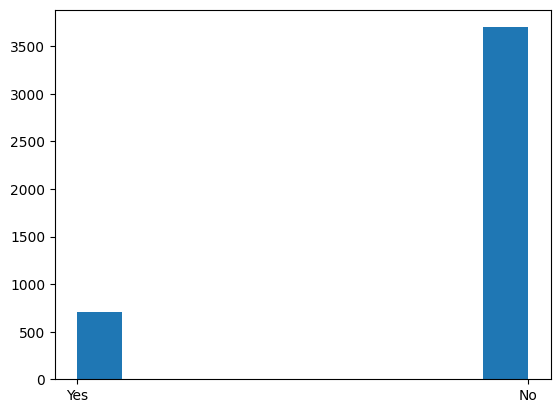

In [15]:
# import matplotlib.pyplot as plt

# Crear un histograma de la variable objetivo
plt.hist(df['Attrition'])
plt.show()


Tal y como se muestra en el gráfico, hay una mayor proporción de `No` que de `Yes`, por lo que estamos ante un problema desbalanceado. Sin embargo, para estudiarlo más en profundidad, calculamos la proporción de observaciones en cada conjunto de entrenamiento y test.

In [16]:
N_SAMPLES_NEG = 3699
N_SAMPLES_POS = 711

In [17]:
from sklearn.model_selection import train_test_split, StratifiedKFold
import numpy as np
# Vamos a comenzar realizando una división train/test "normal".
X_train_no_strat, X_test_no_strat, y_train_no_strat, y_test_no_strat = train_test_split(X, y, test_size=1/3)


# Comprobemos ahora la distribución de las clases.
n_pos_pct = N_SAMPLES_POS / (N_SAMPLES_POS + N_SAMPLES_NEG)
n_pos_train_pct = np.sum(y_train_no_strat=="Yes") / len(y_train_no_strat)
n_pos_test_pct = np.sum(y_test_no_strat=="Yes") / len(y_test_no_strat)

print(f"Hay un {100 * n_pos_train_pct:.1f} % de instancias positivas en train.")
print(f"Hay un {100 * n_pos_test_pct:.1f} % de instancias positivas en test.")
print(f"Hay un {100 * n_pos_pct:.1f} % de instancias positivas en total.")

Hay un 15.6 % de instancias positivas en train.
Hay un 17.1 % de instancias positivas en test.
Hay un 16.1 % de instancias positivas en total.


Basándonos en los resultados obtenidos, podemos afirmar que los datos están desbalanceados. Al analizar la proporción de instancias positivas en el conjunto de train y test, observamos que esta proporción es de alrededor del 16%, lo que significa que la clase minoritaria está subrepresentada, por lo que procedemos a hacer una `división estratificada`


In [18]:

# Comprobemos ahora la distribución de las clases.
n_pos_pct = N_SAMPLES_POS / (N_SAMPLES_POS + N_SAMPLES_NEG)
n_pos_train_pct = np.sum(y_train=="Yes") / len(y_train)
n_pos_test_pct = np.sum(y_test=="Yes") / len(y_test)

print(f"Hay un {100 * n_pos_train_pct:.1f} % de instancias positivas en train.")
print(f"Hay un {100 * n_pos_test_pct:.1f} % de instancias positivas en test.")
print(f"Hay un {100 * n_pos_pct:.1f} % de instancias positivas en total.")

Hay un 16.1 % de instancias positivas en train.
Hay un 16.1 % de instancias positivas en test.
Hay un 16.1 % de instancias positivas en total.


Por lo tanto, se trata de un problema de clasificación binaria ya que el objetivo es predecir si los trabajadores abandonarán su puesto de trabajo o no, es decir, la variable de salida se trata de una variable categórica (*si* o *no*)

---
# **Evaluación de modelos**

Los modelos que se van a utilizar son: `LogisticRegression`, `HistGradientBoosting` y `XGBoosting`. Además, las métricas para la evaluación de estos son los siguientes.

* ``f1_score``: combina la precisión y la exhaustividad en una sola métrica para evaluar la calidad de un modelo de clasificación.
* ``balanced_accuracy``: una métrica de evaluación que tiene en cuenta el desequilibrio de clases en un conjunto de datos.
* ``confusion_matrix``: una tabla que muestra el número de verdaderos positivos, verdaderos negativos, falsos positivos y falsos negativos de un modelo de clasificación.

El objetivo tras esta evaluación es predecir la cantidad de gente que experimenta el ``Burnout` y dadas unas características predecir si se van a ir o no de la empresa y ver qué método es el más adecuado.

## **Dummy classifier**

Antes de pasar a evaluar los modelos adecuados, hacemos un ``DummyClassifier`` para partir de los peores datos que se pueden obtener de f2score, balanced accuracy y matriz de confusión.

In [19]:
from sklearn.dummy import DummyClassifier

# Crear el dummy classifier
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train_processed, y_train)

# Realizar predicciones en los datos de prueba
y_pred = dummy.predict(X_test_processed)

# Calcular las métricas de clasificación


In [20]:
from sklearn.metrics import f1_score, balanced_accuracy_score, confusion_matrix
print("##### F1 ####")
print(f1_score(y_test, y_pred, average='binary', pos_label='Yes'))
print("##### BALANCED ACCURACY ####")
print(balanced_accuracy_score(y_test, y_pred))
print("##### CONFUSION MATRIX ####")
print(confusion_matrix(y_test, y_pred))

##### F1 ####
0.0
##### BALANCED ACCURACY ####
0.5
##### CONFUSION MATRIX ####
[[1233    0]
 [ 237    0]]


Como era de esperar, la métrica de balanced accurary da como resultado el peor valor posible dentro de los valores aceptados, es decir, la media. En cuanto al F1_score, debido a que el F1 score está predicido por un dummy classifier, puede indicar que el conjunto de datos es fácil de clasificar. Sin embargo es importante analizar otras métricas para obtener una evaluación más completa del desempeño del modelo, por lo que además se utilizan más métricas como confusion_matrix, balanced_accurary...

## **Método base: Logistic Regression**

El método de `Regresión Logística` se utiliza para predecir la probabilidad de pertenencia a una de dos clases posibles, en este caso sería *Yes* o *No* de la columna que queremos predecir (Attrition). El modelo de regresión logística se ajusta a los datos de entrenamiento mediante la minimización de una función de costo que mide la discrepancia entre las probabilidades predichas por el modelo y las etiquetas reales de los datos de entrenamiento. Una vez que el modelo se ha ajustado a los datos de entrenamiento, se puede utilizar para hacer predicciones sobre datos nuevos o no vistos anteriormente.


In [21]:
from sklearn.metrics import f1_score, balanced_accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Normalizar los datos de entrenamiento y prueba
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_processed)
X_test_scaled = scaler.transform(X_test_processed)

# Entrenar el modelo de regresión logística
logreg = LogisticRegression(class_weight='balanced')
logreg.fit(X_train_scaled, y_train)

# Realizar predicciones en los datos de prueba
y_pred = logreg.predict(X_test_scaled)

# Calcular las métricas de clasificación
print("##### F1 ####")
print(f1_score(y_test, y_pred, average='binary', pos_label='Yes'))
print("##### BALANCED ACCURACY ####")
print(balanced_accuracy_score(y_test, y_pred))
print("##### CONFUSION MATRIX ####")
print(confusion_matrix(y_test, y_pred))


##### F1 ####
0.3946308724832215
##### BALANCED ACCURACY ####
0.6637356658145719
##### CONFUSION MATRIX ####
[[872 361]
 [ 90 147]]


Como se puede apreciar, los resultados obtenidos son notablemente mejores que en los obtenidos con el Dummy. Sin embargo, estos datos seguramente puedan mejorarse de forma significativa, ya que la cantidad de datos realmente positivos clasificados como negativos es relativamente alta, y en este problema es interesante evaluar la cantidad de gente que sí quiere irse de la empresa.

## **Método avanzado: Histogram Gradient Boosting**

Se ha eligido como método avanzado de boosting, el tipo Histogram Gradient, debido a que puede que funcione mejor términos de precisión o capacidad de generalización para este problema y además nos permite trabajar con problemas desbalanceados, como lo es este. 

Primero ajustamos hiperparámetros. Los hiperparámetros que vamos a ajsutar son los siguientes:

* ``learning_rate``: es la tasa de aprendizaje, que controla la magnitud de los ajustes de los pesos de los árboles de decisión en cada iteración del algoritmo. Un valor más bajo puede permitir un mejor ajuste, pero aumenta el tiempo de entrenamiento y el riesgo de sobreajuste.
* ``max_depth``: es la profundidad máxima permitida para cada árbol de decisión. Un valor más alto puede permitir un mejor ajuste, pero aumenta el riesgo de sobreajuste.
* ``max_leaf_nodes``: es el número máximo de nodos hoja permitidos en cada árbol de decisión. Un valor más alto puede permitir un mejor ajuste, pero aumenta el riesgo de sobreajuste.
* ``min_samples_leaf``: es el número mínimo de muestras requeridas para cada nodo hoja en cada árbol de decisión. Un valor más alto puede ayudar a evitar el sobreajuste y mejorar la generalización, pero puede reducir la capacidad del modelo para capturar patrones subyacentes en los datos.


In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold


# Definir los parámetros a ajustar y sus valores posibles
param_grid = {
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 7],
    'min_samples_leaf': [1, 5, 10],
    'max_leaf_nodes': [None, 10, 20]
}
# Crear un objeto de GradientBoostingClassifier
model = HistGradientBoostingClassifier(class_weight='balanced')

# Crear un objeto de StratifiedKFold
cv = StratifiedKFold(n_splits=5)

# Crear un objeto de GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='balanced_accuracy')

# Ajustar el modelo con los datos de entrenamiento
grid_search.fit(X_train_processed, y_train)

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_

print(best_params)

{'learning_rate': 0.5, 'max_depth': 5, 'max_leaf_nodes': 20, 'min_samples_leaf': 10}


Una vez obtenidos los hiperparámetros que son óptimos para nuestro modelo, pasamos a evaluarlo.

In [34]:

# Crear un objeto de GradientBoostingClassifier
model = HistGradientBoostingClassifier(class_weight='balanced', learning_rate=0.5, max_depth=5, max_leaf_nodes=20, min_samples_leaf=10)
model.fit(X_train_processed, y_train)
y_pred= model.predict(X_test_processed)

print("##### F1 #####")
print(f1_score(y_test, y_pred, average='binary', pos_label='Yes'))
print("##### BALANCED ACCURACY #####")
print(balanced_accuracy_score(y_test, y_pred))
print("##### CONFUSION MATRIX #####")
print(confusion_matrix(y_test, y_pred))


##### F1 #####
0.7312348668280872
##### BALANCED ACCURACY #####
0.8084275257425031
##### CONFUSION MATRIX #####
[[1208   25]
 [  86  151]]


Los resultados obtenidos son notablemente mejores que el anterior método de `LogisticRegression`. Ya que mejora tanto en las predicciones de instancias realmente positivas clasificadas como positivas y en instancias realmente negativas clasificadasd comom negativas.

## **Método avanzado: Xgboost Gradient**

Se ha decidido utilizar el método avanzado `Xgboost` con el fin de tener un modelo más para poder obtener más variedad de resultados a la hora de poder escoger el que será el modelo final. Es un algoritmo de boosting basado en árboles de decisión que utiliza gradientes para mejorar la precisión de las predicciones. El enfoque de XGBoost combina la idea de boosting y la regularización para reducir el sobreajuste y mejorar la generalización del modelo.

In [32]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder


le = LabelEncoder()
y_train_transformed = le.fit_transform(y_train)
y_test_transformed= le.fit_transform(y_test)


#Crear un objeto DMatrix a partir de los datos de entrenamiento y prueba
dtrain = xgb.DMatrix(X_train_processed, label=y_train_transformed)
dtest = xgb.DMatrix(X_test_processed, label=y_test_transformed)

# Definir los hiperparámetros del modelo y los valores a explorar en la búsqueda por grilla
params = {
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 2, 3],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Crear un objeto XGBoost clasificador
xgb_model = xgb.XGBClassifier(objective='binary:logistic', seed=42)

# Realizar la búsqueda por grilla
grid_search = GridSearchCV(xgb_model, param_grid=params, scoring='balanced_accuracy', cv=cv, n_jobs=-1)
grid_search.fit(X_train_processed, y_train_transformed)

# Obtener los mejores hiperparámetros encontrados por la búsqueda por grilla
best_params = grid_search.best_params_

print(best_params)



{'colsample_bytree': 0.6, 'max_depth': 5, 'min_child_weight': 1}


In [33]:
import xgboost as xgb
from sklearn.metrics import f1_score, balanced_accuracy_score, confusion_matrix
import numpy as np

# Calcular la proporción de la clase mayoritaria y la clase minoritaria
prop_majority = np.sum(y_train_transformed == 0) / len(y_train_transformed)
prop_minority = np.sum(y_train_transformed == 1) / len(y_train_transformed)

# Crear un objeto DMatrix a partir de los datos de entrenamiento y prueba
dtrain = xgb.DMatrix(X_train_processed, label=y_train_transformed)
dtest = xgb.DMatrix(X_test_processed, label=y_test_transformed)

# Definir los hiperparámetros del modelo
params = {
    'objective': 'binary:logistic',
    'max_depth': 5,
    'min_child_weight': 1,
    'colsample_bytree': 0.6,
    'scale_pos_weight': prop_majority / prop_minority
}

# Entrenar el modelo
num_rounds = 100
xgb_model = xgb.train(params, dtrain, num_rounds)

# Realizar predicciones en los datos de prueba
y_pred = xgb_model.predict(dtest)
y_pred = [round(value) for value in y_pred]

# Calcular las métricas de clasificación
print("##### F1 ####")
print(f1_score(y_test_transformed, y_pred))
print("##### BALANCED ACCURACY ####")
print(balanced_accuracy_score(y_test_transformed, y_pred))
print("##### CONFUSION MATRIX ####")
print(confusion_matrix(y_test_transformed, y_pred))

##### F1 ####
0.7552447552447552
##### BALANCED ACCURACY ####
0.8296067017770796
##### CONFUSION MATRIX ####
[[1203   30]
 [  75  162]]


Este es el mejor modelo obtenido hasta el momento, ya que las métricas han mejorado notablemente con respecto a los dos modelos anteriores.

---
# Selección de atributos

En este punto se realizará una selección de los atributos para saber qué atributos son más importantes. Además, se comprobará el resultado obtenido con los métodos utilizados anteriormente para ver si ha habido alguna mejoría.

Para la selección de atributos se ha seguido la misma lógica para los 3 modelos, es decir, primero calculamos el f1_score y balanced_accuracy para cada posible valor de k, siendo k el número de atributos relevantes para el modelo. Una vez hecho esto, se hace un gráfico con la evolución de todas las características y se elige el mejor.

## **Logistic Regression**

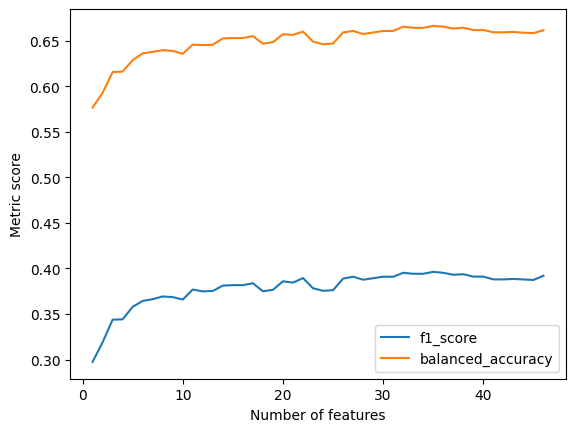

In [35]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif

scaler =  MinMaxScaler()
selector = SelectKBest(f_classif)
logreg = LogisticRegression(class_weight='balanced')

pipe_select_logreg = Pipeline([
    ('scaler', scaler),
    ('select', selector),
    ('logreg', logreg)
])

# Listas para guardar los resultados de las métricas
f1_scores = []
balanced_accuracies = []

# Probar diferentes valores de k
for k in range(1, X_train_processed.shape[1] + 1):
    selector.set_params(k=k)
    pipe_select_logreg.fit(X_train_processed, y_train)
    y_pred_logreg = pipe_select_logreg.predict(X_test_processed)
    f1 = f1_score(y_test, y_pred_logreg, average='binary', pos_label='Yes')
    balanced_acc = balanced_accuracy_score(y_test, y_pred_logreg)
    f1_scores.append(f1)
    balanced_accuracies.append(balanced_acc)
   # print(f"k={k}, f1_score={f1}, balanced_accuracy={balanced_acc}")

# Graficar los resultados
plt.plot(range(1, X_train_processed.shape[1] + 1), f1_scores, label="f1_score")
plt.plot(range(1, X_train_processed.shape[1] + 1), balanced_accuracies, label="balanced_accuracy")
plt.xlabel("Number of features")
plt.ylabel("Metric score")
plt.legend()
plt.show()

Como se puede apreciar en el gráfico, a partir de 18 atributos se puede observar que los valores para f1 score y balanced se empiezan a estabilizar.

In [36]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
logreg = LogisticRegression(class_weight='balanced')
# Seleccionar los 10 atributos más importantes usando SelectKBest y f_classif
selector = SelectKBest(score_func=f_classif, k=18)


pipe_select_scale_log_reg = Pipeline([
    ('scale', scaler),
    ('select', selector),
    ('logreg', logreg)
])

pipe_select_scale_log_reg.fit(X_train_processed, y_train)

pipe_select_scale_log_reg.named_steps

{'scale': StandardScaler(),
 'select': SelectKBest(k=18),
 'logreg': LogisticRegression(class_weight='balanced')}

In [37]:
import numpy as np

print(f"Features selected: {pipe_select_scale_log_reg.named_steps['select'].get_support()}")

print(f"Locations where features selected: {np.where(pipe_select_scale_log_reg.named_steps['select'].get_support())}")

feature_names_before_selection = pipe_select_scale_log_reg.named_steps['scale'].get_feature_names_out()
print(f"Feature names after selection: {pipe_select_scale_log_reg.named_steps['select'].get_feature_names_out(feature_names_before_selection)}")

Features selected: [ True  True False False  True  True  True  True False False False False
 False False False  True  True  True False  True  True  True  True False
 False False  True False False False False False False False False False
 False False False False  True False False  True  True  True]
Locations where features selected: (array([ 0,  1,  4,  5,  6,  7, 15, 16, 17, 19, 20, 21, 22, 26, 40, 43, 44,
       45]),)
Feature names after selection: ['num__hrs' 'num__absences' 'num__EnvironmentSatisfaction'
 'num__JobSatisfaction' 'num__WorkLifeBalance' 'num__Age'
 'num__TotalWorkingYears' 'num__TrainingTimesLastYear'
 'num__YearsAtCompany' 'num__YearsWithCurrManager'
 'cat__BusinessTravel_Non-Travel' 'cat__BusinessTravel_Travel_Frequently'
 'cat__BusinessTravel_Travel_Rarely' 'cat__EducationField_Human Resources'
 'cat__JobRole_Research Scientist' 'cat__MaritalStatus_Divorced'
 'cat__MaritalStatus_Married' 'cat__MaritalStatus_Single']


Evaluación del modelo

In [38]:
y_pred_logreg = pipe_select_scale_log_reg.predict(X_test_processed)

# Calcular las métricas de clasificación
print("##### F1 ####")
print(f1_score(y_test, y_pred_logreg, average='binary', pos_label='Yes'))
print("##### BALANCED ACCURACY ####")
print(balanced_accuracy_score(y_test, y_pred_logreg))
print("##### CONFUSION MATRIX ####")
print(confusion_matrix(y_test, y_pred_logreg))

##### F1 ####
0.37209302325581395
##### BALANCED ACCURACY ####
0.6444300717607564
##### CONFUSION MATRIX ####
[[840 393]
 [ 93 144]]


Como se puede observar, no se ha obtenido una mejoría notoria en este modelo con selección de atributos.

## **Histogram Gradient Boosting**

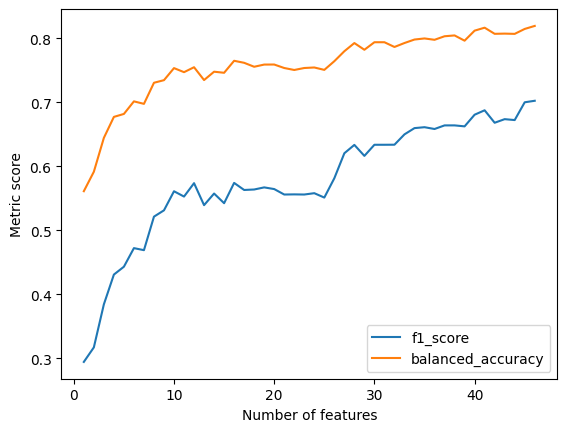

In [39]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, balanced_accuracy_score
import matplotlib.pyplot as plt

scaler =  MinMaxScaler()
selector = SelectKBest(f_classif)
grad_boosting = HistGradientBoostingClassifier(class_weight='balanced', learning_rate=0.1, max_depth=7, max_leaf_nodes=20, min_samples_leaf=1)

pipe_select_gradboost = Pipeline([
    ('scaler', scaler),
    ('select', selector),
    ('gradient', grad_boosting)
])

# Listas para guardar los resultados de las métricas
f1_scores = []
balanced_accuracies = []

# Probar diferentes valores de k
for k in range(1, X_train_processed.shape[1] + 1):
    selector.set_params(k=k)
    pipe_select_gradboost.fit(X_train_processed, y_train_transformed)
    y_pred_grad = pipe_select_gradboost.predict(X_test_processed)
    f1 = f1_score(y_test_transformed, y_pred_grad, average='binary', pos_label=1)
    balanced_acc = balanced_accuracy_score(y_test_transformed, y_pred_grad)
    f1_scores.append(f1)
    balanced_accuracies.append(balanced_acc)
   # print(f"k={k}, f1_score={f1}, balanced_accuracy={balanced_acc}")

# Graficar los resultados
plt.plot(range(1, X_train_processed.shape[1] + 1), f1_scores, label="f1_score")
plt.plot(range(1, X_train_processed.shape[1] + 1), balanced_accuracies, label="balanced_accuracy")
plt.xlabel("Number of features")
plt.ylabel("Metric score")
plt.legend()
plt.show()

In [40]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

scaler =  MinMaxScaler()
selector = SelectKBest(f_classif, k=32)
grad_boosting = HistGradientBoostingClassifier(class_weight='balanced', learning_rate=0.1, max_depth=7, max_leaf_nodes=20, min_samples_leaf=1)

pipe_select_gradboost = Pipeline([
    ('scaler', scaler),
    ('select', selector),
    ('gradient', grad_boosting)
])

pipe_select_gradboost.fit(X_train_processed, y_train_transformed)

pipe_select_gradboost.named_steps


{'scaler': MinMaxScaler(),
 'select': SelectKBest(k=32),
 'gradient': HistGradientBoostingClassifier(class_weight='balanced', max_depth=7,
                                max_leaf_nodes=20, min_samples_leaf=1)}

In [41]:
import numpy as np

print(f"Features selected: {pipe_select_gradboost.named_steps['select'].get_support()}")

print(f"Locations where features selected: {np.where(pipe_select_gradboost.named_steps['select'].get_support())}")

feature_names_before_selection = pipe_select_gradboost.named_steps['scaler'].get_feature_names_out()
print(f"Feature names after selection: {pipe_select_gradboost.named_steps['select'].get_feature_names_out(feature_names_before_selection)}")

Features selected: [ True  True  True False  True  True  True  True False  True False  True
  True  True False  True  True  True False  True  True  True  True  True
 False  True  True False  True False False  True  True  True False False
 False  True  True  True  True False False  True  True  True]
Locations where features selected: (array([ 0,  1,  2,  4,  5,  6,  7,  9, 11, 12, 13, 15, 16, 17, 19, 20, 21,
       22, 23, 25, 26, 28, 31, 32, 33, 37, 38, 39, 40, 43, 44, 45]),)
Feature names after selection: ['num__hrs' 'num__absences' 'num__JobInvolvement'
 'num__EnvironmentSatisfaction' 'num__JobSatisfaction'
 'num__WorkLifeBalance' 'num__Age' 'num__Education' 'num__MonthlyIncome'
 'num__NumCompaniesWorked' 'num__PercentSalaryHike'
 'num__TotalWorkingYears' 'num__TrainingTimesLastYear'
 'num__YearsAtCompany' 'num__YearsWithCurrManager'
 'cat__BusinessTravel_Non-Travel' 'cat__BusinessTravel_Travel_Frequently'
 'cat__BusinessTravel_Travel_Rarely' 'cat__Department_Human Resources'
 'cat__

Evaluación del modelo

In [42]:
y_pred_grad = pipe_select_gradboost.predict(X_test_processed)

# Calcular las métricas de clasificación
print("##### F1 ####")
print(f1_score(y_test_transformed, y_pred_grad, average='binary', pos_label=1))
print("##### BALANCED ACCURACY ####")
print(balanced_accuracy_score(y_test_transformed, y_pred_grad))
print("##### CONFUSION MATRIX ####")
print(confusion_matrix(y_test_transformed, y_pred_grad))

##### F1 ####
0.6337448559670782
##### BALANCED ACCURACY ####
0.7863705893826932
##### CONFUSION MATRIX ####
[[1138   95]
 [  83  154]]


En este modelo se observa una ligera mejoría con respecto al que no tenía selección de atributos.

## **XGB**

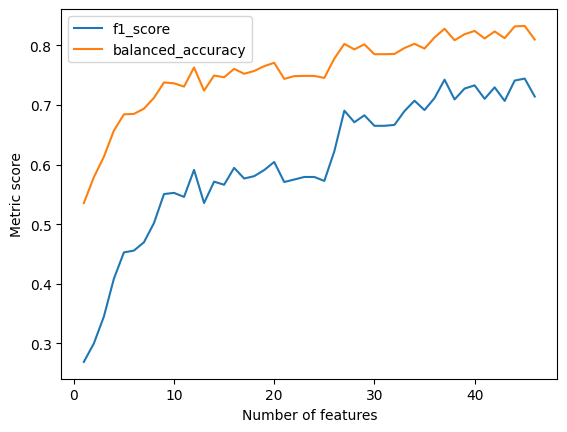

In [44]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, balanced_accuracy_score
import matplotlib.pyplot as plt

scaler = MinMaxScaler()
selector = SelectKBest(f_classif)
xgb_clf = XGBClassifier(max_depth=4, min_child_weight=1, n_estimators=150, scale_pos_weight=(prop_majority/prop_minority))

pipe_select_xgb = Pipeline([
    ('scaler', scaler),
    ('select', selector),
    ('xgb', xgb_clf)
])

# Listas para guardar los resultados de las métricas
f1_scores = []
balanced_accuracies = []

# Probar diferentes valores de k
for k in range(1, X_train_processed.shape[1] + 1):
    selector.set_params(k=k)
    pipe_select_xgb.fit(X_train_processed, y_train_transformed)
    y_pred_xgb = pipe_select_xgb.predict(X_test_processed)
    f1 = f1_score(y_test_transformed, y_pred_xgb, average='binary', pos_label=1)
    balanced_acc = balanced_accuracy_score(y_test_transformed, y_pred_xgb)
    f1_scores.append(f1)
    balanced_accuracies.append(balanced_acc)
    #print(f"k={k}, f1_score={f1}, balanced_accuracy={balanced_acc}")

# Graficar los resultados
plt.plot(range(1, X_train_processed.shape[1] + 1), f1_scores, label="f1_score")
plt.plot(range(1, X_train_processed.shape[1] + 1), balanced_accuracies, label="balanced_accuracy")
plt.xlabel("Number of features")
plt.ylabel("Metric score")
plt.legend()
plt.show()

In [45]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
selector = SelectKBest(f_classif, k=31)
xgb_clf = XGBClassifier(max_depth=4, min_child_weight=1, n_estimators=150, scale_pos_weight=(prop_majority/prop_minority))

pipe_select_xgb = Pipeline([
    ('scaler', scaler),
    ('select', selector),
    ('xgb', xgb_clf)
])

pipe_select_xgb.fit(X_train_processed, y_train_transformed)

pipe_select_xgb.named_steps


{'scaler': MinMaxScaler(),
 'select': SelectKBest(k=31),
 'xgb': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=4, max_leaves=None,
               min_child_weight=1, missing=nan, monotone_constraints=None,
               n_estimators=150, n_jobs=None, num_parallel_tree=None,
               predictor=None, random_state=None, ...)}

In [46]:
import numpy as np

print(f"Features selected: {pipe_select_xgb.named_steps['select'].get_support()}")

print(f"Locations where features selected: {np.where(pipe_select_xgb.named_steps['select'].get_support())}")

feature_names_before_selection = pipe_select_xgb.named_steps['scaler'].get_feature_names_out()
print(f"Feature names after selection: {pipe_select_xgb.named_steps['select'].get_feature_names_out(feature_names_before_selection)}")

Features selected: [ True  True  True False  True  True  True  True False False False  True
  True  True False  True  True  True False  True  True  True  True  True
 False  True  True False  True False False  True  True  True False False
 False  True  True  True  True False False  True  True  True]
Locations where features selected: (array([ 0,  1,  2,  4,  5,  6,  7, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22,
       23, 25, 26, 28, 31, 32, 33, 37, 38, 39, 40, 43, 44, 45]),)
Feature names after selection: ['num__hrs' 'num__absences' 'num__JobInvolvement'
 'num__EnvironmentSatisfaction' 'num__JobSatisfaction'
 'num__WorkLifeBalance' 'num__Age' 'num__MonthlyIncome'
 'num__NumCompaniesWorked' 'num__PercentSalaryHike'
 'num__TotalWorkingYears' 'num__TrainingTimesLastYear'
 'num__YearsAtCompany' 'num__YearsWithCurrManager'
 'cat__BusinessTravel_Non-Travel' 'cat__BusinessTravel_Travel_Frequently'
 'cat__BusinessTravel_Travel_Rarely' 'cat__Department_Human Resources'
 'cat__Department_Sales' 'ca

In [47]:
y_pred_xgb = pipe_select_xgb.predict(X_test_processed)

# Calcular las métricas de clasificación
print("##### F1 ####")
print(f1_score(y_test_transformed, y_pred_xgb, average='binary', pos_label=1))
print("##### BALANCED ACCURACY ####")
print(balanced_accuracy_score(y_test_transformed, y_pred_xgb))
print("##### CONFUSION MATRIX ####")
print(confusion_matrix(y_test_transformed, y_pred_xgb))

##### F1 ####
0.6651480637813212
##### BALANCED ACCURACY ####
0.7853080374100424
##### CONFUSION MATRIX ####
[[1177   56]
 [  91  146]]


En el último modelo, podemos ver que no ha habido una mejora significativa. 


---
## Conclusiones

Antes de realizar el modelo final, se representarán todos los datos obtenidos hasta el momento con todas las métricas de evaluación utilizadas (f1_score, balanced_accuracy, confusion_matrix).

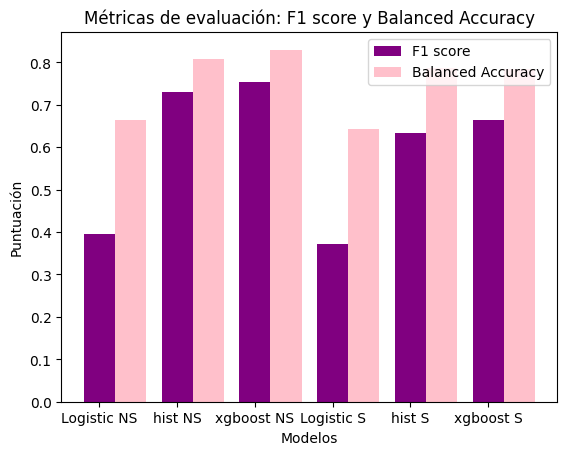

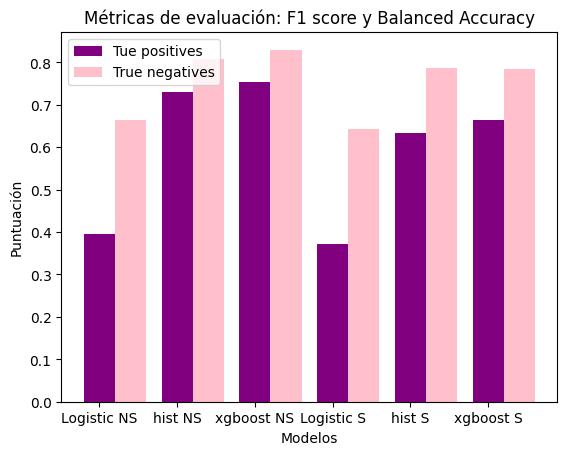

In [65]:
import matplotlib.pyplot as plt

# Definir los valores del F1 score y Balanced Accuracy para cada modelo
logNS_f1_score = 0.395
histNS_f1_score = 0.731
xgNS_f1_score = 0.755
logS_f1_score = 0.372
histS_f1_score = 0.634
xgS_f1_score = 0.665

logNS_balanced_accuracy = 0.664
histNS_balanced_accuracy = 0.808
xgNS_balanced_accuracy = 0.830
logS_balanced_accuracy = 0.644
histS_balanced_accuracy = 0.786
xgS_balanced_accuracy = 0.785

# Crear una lista con los nombres de los modelos
model_names = ['Logistic NS', 'hist NS', 'xgboost NS', 'Logistic S', 'hist S', 'xgboost S']

# Crear una lista con los valores de F1 score y Balanced Accuracy para cada modelo
f1_scores = [logNS_f1_score, histNS_f1_score, xgNS_f1_score, logS_f1_score, histS_f1_score, xgS_f1_score]
balanced_accuracies = [logNS_balanced_accuracy, histNS_balanced_accuracy, xgNS_balanced_accuracy, logS_balanced_accuracy, histS_balanced_accuracy, xgS_balanced_accuracy]

# Crear un gráfico de barras para los valores del F1 score
plt.bar(range(len(model_names)), f1_scores, color='purple', width=0.4)

# Agregar una segunda serie de barras para los valores de Balanced Accuracy
plt.bar([x + 0.4 for x in range(len(model_names))], balanced_accuracies, color='pink', width=0.4)

# Establecer las etiquetas de las barras en los nombres de los modelos
plt.xticks(range(len(model_names)), model_names)

# Agregar leyendas y etiquetas

plt.xlabel('Modelos')
plt.ylabel('Puntuación')
plt.title('Métricas de evaluación: F1 score y Balanced Accuracy')
plt.legend(['F1 score', 'Balanced Accuracy'])

# Mostrar el gráfico
plt.show()





import matplotlib.pyplot as plt

# Definir los valores del F1 score y Balanced Accuracy para cada modelo

logNS_f1_TP = 872
histNS_f1_TP = 1208
xgNS_f1_TP = 1203
logS_f1_TP = 840
histS_f1_TP = 1138
xgS_f1_TP = 1177

logNS_TN = 147
histNS_TN = 151
xgNS_TN = 162
logS_TN = 144
histS_TN = 154
xgS_TN = 146

# Crear una lista con los nombres de los modelos
model_names = ['Logistic NS', 'hist NS', 'xgboost NS', 'Logistic S', 'hist S', 'xgboost S']

# Crear una lista con los valores de TP y TN para cada modelo
true_negatives= [logNS_TN, histNS_TN, xgNS_TN, logS_TN, histS_TN, xgS_TN]
true_positives =[logNS_f1_TP, histNS_f1_TP, xgNS_f1_TP, logS_f1_TP, histS_f1_TP, xgS_f1_TP]


# Crear un gráfico de barras para los valores del F1 score
plt.bar(range(len(model_names)), f1_scores, color='purple', width=0.4)

# Agregar una segunda serie de barras para los valores de Balanced Accuracy
plt.bar([x + 0.4 for x in range(len(model_names))], balanced_accuracies, color='pink', width=0.4)

# Establecer las etiquetas de las barras en los nombres de los modelos
plt.xticks(range(len(model_names)), model_names)

# Agregar leyendas y etiquetas

plt.xlabel('Modelos')
plt.ylabel('Puntuación')
plt.title('Métricas de evaluación: F1 score y Balanced Accuracy')
plt.legend(['Tue positives', 'True negatives'])

# Mostrar el gráfico
plt.show()





En la gráfica se ven representados todos los datos tanto de f1_score como de balanced_accuracy. En los nombres de los modelos, cuando hay *NS* quiere decir que no ha habido selección de atributos y cuando se incluye *S* quiere decir que sí. 

Como se ve en la gráfica, cuando hay selección de atributos y cuando no lo hay, no se ve una mejora muy notable. Aun así, hemos optado por elegir el **método de XGBOOST con la selección de atributos** ya que el resultado que se obtiene para las medidas de F1_score y Balanced Accuacy a pesar de no ser excesivamente mejor al del mismo modelo sin la selección de atributos, consigue ser muy similar pero además con la ventaja de no tener atributos irrelevantes. Esto es una ventaja ya que el modelo predecirá los datos más rápidos, y en cuanto al marco del estudio representa otra ventaja ya que de cara a evaluar a los trabajadores, las encuestas serán más reducidas que inicialmente ya que ahora habrá menos atributos.




---

# **Modelo final**

Como hemos podido observar en las gráficas, el mejor modelo obtenido ha sido **``XGboost``** ya que con la reducción del número de atributos, el modelo sigue devolviendo métricas muy similares a las obtenidas sin la selección de atributos.

In [56]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
selector = SelectKBest(f_classif, k=31)
xgb_clf = XGBClassifier(max_depth=4, min_child_weight=1, n_estimators=150, scale_pos_weight=(prop_majority/prop_minority))

pipe_select_xgb = Pipeline([
    ('scaler', scaler),
    ('select', selector),
    ('xgb', xgb_clf)
])

pipe_select_xgb.fit(X_train_processed, y_train_transformed)

pipe_select_xgb.named_steps

{'scaler': MinMaxScaler(),
 'select': SelectKBest(k=31),
 'xgb': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=4, max_leaves=None,
               min_child_weight=1, missing=nan, monotone_constraints=None,
               n_estimators=150, n_jobs=None, num_parallel_tree=None,
               predictor=None, random_state=None, ...)}

Procedemos a guardar el modelo en modelo_final.pkl

In [57]:
import pickle

with open('modelo_final.pkl', 'wb') as f:
    pickle.dump(pipe_select_xgb, f)